Практическое задание:

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для:
6. всего тестового набора данных (summary_plot - дать интерпретацию):
    * для топ 10%
    * для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

import shap
shap.initjs()

import matplotlib.pyplot as plt

%matplotlib inline

Для примера выберем <a href="https://archive-beta.ics.uci.edu/ml/datasets/car+evaluation">датасет об определении абстрактной "приемлемости" автомобиля</a>. В данном случае количество признаков подобрано не слишком большим, что снижает потенциальное время расчета методов SHAP.

In [2]:
DATA_PATH = Path('data/')
DATASET = 'car.data'
DATASET_NAMES = 'car.names'
df = pd.read_csv(DATA_PATH / DATASET, header=None)
with open(DATA_PATH / DATASET_NAMES, 'r') as f:
    print(f.read())

1. Title: Car Evaluation Database

2. Sources:
   (a) Creator: Marko Bohanec
   (b) Donors: Marko Bohanec   (marko.bohanec@ijs.si)
               Blaz Zupan      (blaz.zupan@ijs.si)
   (c) Date: June, 1997

3. Past Usage:

   The hierarchical decision model, from which this dataset is
   derived, was first presented in 

   M. Bohanec and V. Rajkovic: Knowledge acquisition and explanation for
   multi-attribute decision making. In 8th Intl Workshop on Expert
   Systems and their Applications, Avignon, France. pages 59-78, 1988.

   Within machine-learning, this dataset was used for the evaluation
   of HINT (Hierarchy INduction Tool), which was proved to be able to
   completely reconstruct the original hierarchical model. This,
   together with a comparison with C4.5, is presented in

   B. Zupan, M. Bohanec, I. Bratko, J. Demsar: Machine learning by
   function decomposition. ICML-97, Nashville, TN. 1997 (to appear)

4. Relevant Information Paragraph:

   Car Evaluation Database was 

In [3]:
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


Несмотря на то, что в описании указано, какие значения принимают признаки, удостоверимся в корректности этого и проверим наличие пропущенных значений:

In [4]:
for clm in df.columns:
    print(clm)
    print(dict(df.groupby(clm)[clm].count()))
    print('--------')

buying
{'high': 432, 'low': 432, 'med': 432, 'vhigh': 432}
--------
maint
{'high': 432, 'low': 432, 'med': 432, 'vhigh': 432}
--------
doors
{'2': 432, '3': 432, '4': 432, '5more': 432}
--------
persons
{'2': 576, '4': 576, 'more': 576}
--------
lug_boot
{'big': 576, 'med': 576, 'small': 576}
--------
safety
{'high': 576, 'low': 576, 'med': 576}
--------
class
{'acc': 384, 'good': 69, 'unacc': 1210, 'vgood': 65}
--------


Действительно в датасете отсутствуют пустые значения, а также все признаки представлены как категориальные, которые можно перевести в ранговые/числовые:

In [5]:
class TransformData(TransformerMixin, BaseEstimator):
    def fit(self, X):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['buying'].replace(to_replace=['vhigh', 'high', 'med', 'low'],
                             value=[4, 3, 2, 1],
                             inplace=True)
        X['maint'].replace(to_replace=['vhigh', 'high', 'med', 'low'],
                             value=[4, 3, 2, 1],
                             inplace=True)
        X['doors'].replace(to_replace=['2', '3', '4', '5more'],
                             value=[2, 3, 4, 5],
                             inplace=True)
        X['persons'].replace(to_replace=['2', '4', 'more'],
                             value=[2, 4, 5],
                             inplace=True)
        X['lug_boot'].replace(to_replace=['small', 'med', 'big'],
                             value=[1, 2, 3],
                             inplace=True)
        X['safety'].replace(to_replace=['low', 'med', 'high'],
                             value=[1, 2, 3],
                             inplace=True)
        X['class'].replace(to_replace=['unacc', 'acc', 'vgood', 'good'],
                             value=[0, 1, 1, 1],
                             inplace=True)
        return X

In [6]:
transformator = TransformData()
df_tr = transformator.transform(df)
df_tr.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,2.500000,2.500000,3.500000,3.666667,2.000000,2.000000,0.299769
std,1.118358,1.118358,1.118358,1.247580,0.816733,0.816733,0.458289
min,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
25%,1.750000,1.750000,2.750000,2.000000,1.000000,1.000000,0.000000
50%,2.500000,2.500000,3.500000,4.000000,2.000000,2.000000,0.000000
75%,3.250000,3.250000,4.250000,5.000000,3.000000,3.000000,1.000000
max,4.000000,4.000000,5.000000,5.000000,3.000000,3.000000,1.000000


Перед обучением "выкинем" один признак, т.к. скорее всего датасет искусственный и получаемые в итоге значения предсказаний пододрительно близки к идеалу.

In [141]:
X = df_tr.drop(columns=['class', 'safety'])
y = df_tr['class']

model = RandomForestClassifier()
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)[1]
pred = model.predict_proba(X)

In [148]:
thr = np.quantile(pred[:, 1], 0.9)
mask_10 = pred[:, 1] >= thr

Далее можно построить распределение важности признаков по SHAP:
* сначала для всего датасета

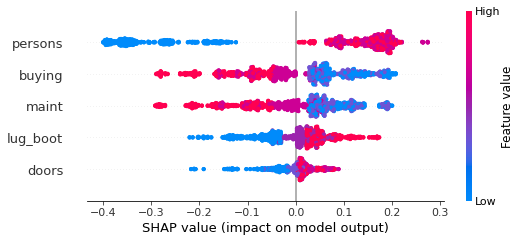

In [147]:
shap.summary_plot(shap_values, X)

* а также для ТОП 10% значений по уверенности предсказаний

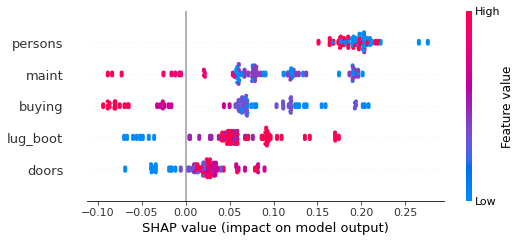

In [158]:
shap.summary_plot(shap_values[mask_10, :], X.loc[mask_10])

На всех наблюдениях видно, что практически каждый признак имеет тенденцию к четкому разделению классов, однако `buying` и `maint` имеют некоторое смешение при небольших положительных значениях. Это может говорить о том, что предпочтительность выбора автомобиля хоть и завивисит от цены, но можно встретить популярные автомобили несколько дороже среднерыночной цены, но выбивающихся за счет других весомых преимуществ.

На ТОП 10% выборке четко видно, что весь этот датасет  имеет признак `persons` в отметках выше среднего по всей выборке, что значит, что в самых предпочтительных автомобилях чаще всего не бывает случаев вместимости до 2 человек. Остальные наблюдения в целом соответствуют всей выборке.

Рассмотрим пример подсчета скора для отдельного наблюдения:

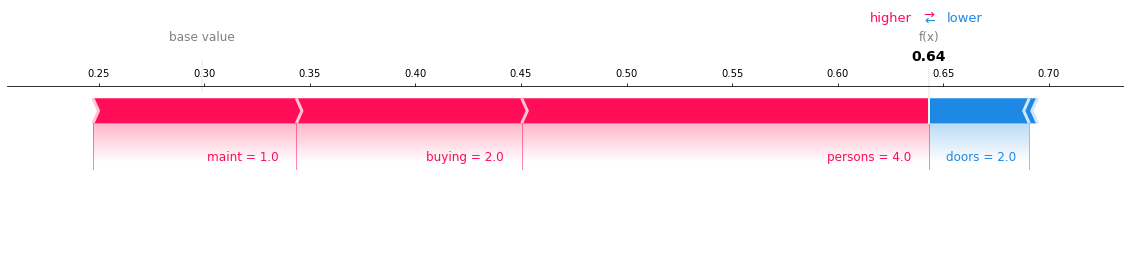

In [167]:
shap.force_plot(explainer.expected_value[1], shap_values[1200, :],
                X.iloc[1200, :], show=False, matplotlib=True)\
                .savefig('my_img.png')

Здесь только признак `doors` "оттягивает" вероятность принадлежности назад, а `lug_boot` вообще практически не влияет на нее. Остальные же признаки увеличивают уверенность модели в том, что класс наблюдения принадлежит единице (увеличивается с базового значения в $\approx 0.3$ путем выбора наугад).

-----
P.S. В случае, если из-за проблем с JS график выге не отображается:

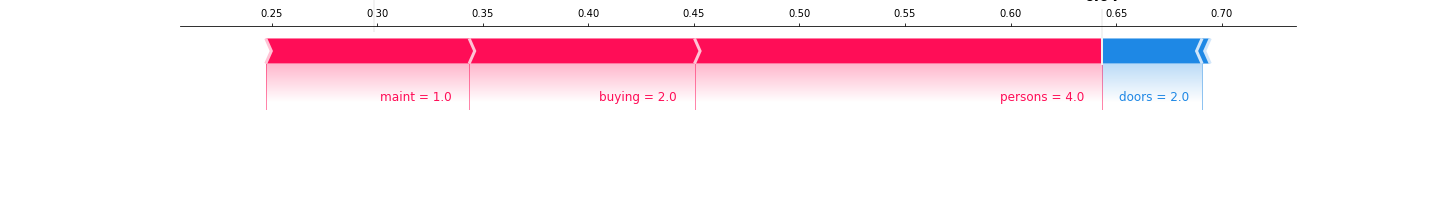